In [95]:
############
# LIBRARIES
############

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Adjusting Row Column Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [96]:
############
# READ DATA
############

final_df = pd.read_csv("/content/drive/MyDrive/Injury Prediction/final_data.csv", parse_dates=['date'])

In [97]:
###############
# DEFINE CLASS
###############

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size // 2, 16)
        self.dropout3 = nn.Dropout(dropout / 2)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.bn1(x[:, -1, :])
        x = self.dropout1(x)

        x, _ = self.lstm2(x.unsqueeze(1))
        x = self.bn2(x[:, -1, :])
        x = self.dropout2(x)

        x = torch.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

# Early stopping
class EarlyStopping:
    def __init__(self, patience=30, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [98]:
##############
# TRAIN MODEL
##############

def prepare_sequences(data, lookback, features, target):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[features].iloc[i:(i + lookback)].values)
        y.append(data[target].iloc[i + lookback])
    return np.array(X), np.array(y)


# Train individual models
def train_individual_models(df, features, target='overall_risk', lookback=14, epochs=200, batch_size=32, patience=50):
    selected_features = features
    results = {}
    summary_results = []
    athlete_ids = df['athlete_id'].unique()

    for athlete_id in athlete_ids:
        athlete_data = df[df['athlete_id'] == athlete_id].copy()
        athlete_data = athlete_data.sort_values('date')

        scaler_features = StandardScaler()
        scaler_target = StandardScaler()

        athlete_data[selected_features] = scaler_features.fit_transform(athlete_data[selected_features])
        athlete_data[target] = scaler_target.fit_transform(athlete_data[[target]])

        X, y = prepare_sequences(athlete_data, lookback, selected_features, target)

        train_size = int(len(X) * 0.7)
        val_size = int(len(X) * 0.2)
        test_size = len(X) - train_size - val_size

        X_train, y_train = X[:train_size], y[:train_size]
        X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
        X_test, y_test = X[-test_size:], y[-test_size:]

        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        model = LSTMModel(input_size=len(selected_features)).to('cpu')
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

        early_stopping = EarlyStopping(patience=patience)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)

            print(f"Athlete {athlete_id} Epoch {epoch}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

            early_stopping(val_loss.item())
            if early_stopping.early_stop:
                print("Early stopping")
                break

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).numpy()

        y_test_orig = scaler_target.inverse_transform(y_test.numpy())
        y_pred_orig = scaler_target.inverse_transform(y_pred)

        mse = mean_squared_error(y_test_orig, y_pred_orig)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_orig, y_pred_orig)
        r2 = r2_score(y_test_orig, y_pred_orig)

        results[athlete_id] = {
            'model': model,
            'scaler_features': scaler_features,
            'scaler_target': scaler_target,
            'metrics': {'mse': mse,'rmse': rmse,'mae': mae,'r2': r2},
            'predictions': {'actual': y_test_orig.flatten(),'predicted': y_pred_orig.flatten()}}

        summary_results.append({'athlete_id': athlete_id,'mse': mse,'rmse': rmse,'mae': mae,'r2': r2,
            'training_samples': len(X_train),'validation_samples': len(X_val),'testing_samples': len(X_test)})

    summary_df = pd.DataFrame(summary_results)
    print("\nAverage Metrics Across All Athletes:")
    print(summary_df[['mse', 'rmse', 'mae', 'r2']].mean())
    print("\nMetrics by Athlete:")
    print(summary_df)

    return results, summary_df


feature = ['hip_mobility', 'groin_squeeze', 'game_workload', 'injuries_status', 'resting',
            'workload_7d', 'acwr', 'workload_change', 'rest_days_7d', 'hip_trend', 'hip_change',
            'groin_trend', 'groin_change', 'injuries_30d', 'days_since_injury', 'workload_risk']

results, summary_df = train_individual_models(final_df, feature)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Athlete 4 Epoch 140/200, Training Loss: 0.1443033069372177, Validation Loss: 0.04504840075969696
Athlete 4 Epoch 141/200, Training Loss: 0.14157457649707794, Validation Loss: 0.037083789706230164
Athlete 4 Epoch 142/200, Training Loss: 0.13864807784557343, Validation Loss: 0.03070029616355896
Athlete 4 Epoch 143/200, Training Loss: 0.14340008795261383, Validation Loss: 0.027026614174246788
Athlete 4 Epoch 144/200, Training Loss: 0.12961600720882416, Validation Loss: 0.024863077327609062
Athlete 4 Epoch 145/200, Training Loss: 0.132912740111351, Validation Loss: 0.023891320452094078
Athlete 4 Epoch 146/200, Training Loss: 0.13624750077724457, Validation Loss: 0.022422386333346367
Athlete 4 Epoch 147/200, Training Loss: 0.11874179542064667, Validation Loss: 0.021946804597973824
Athlete 4 Epoch 148/200, Training Loss: 0.09474141150712967, Validation Loss: 0.021772773936390877
Athlete 4 Epoch 149/200, Training Loss: 0.12769100069999695, Valida

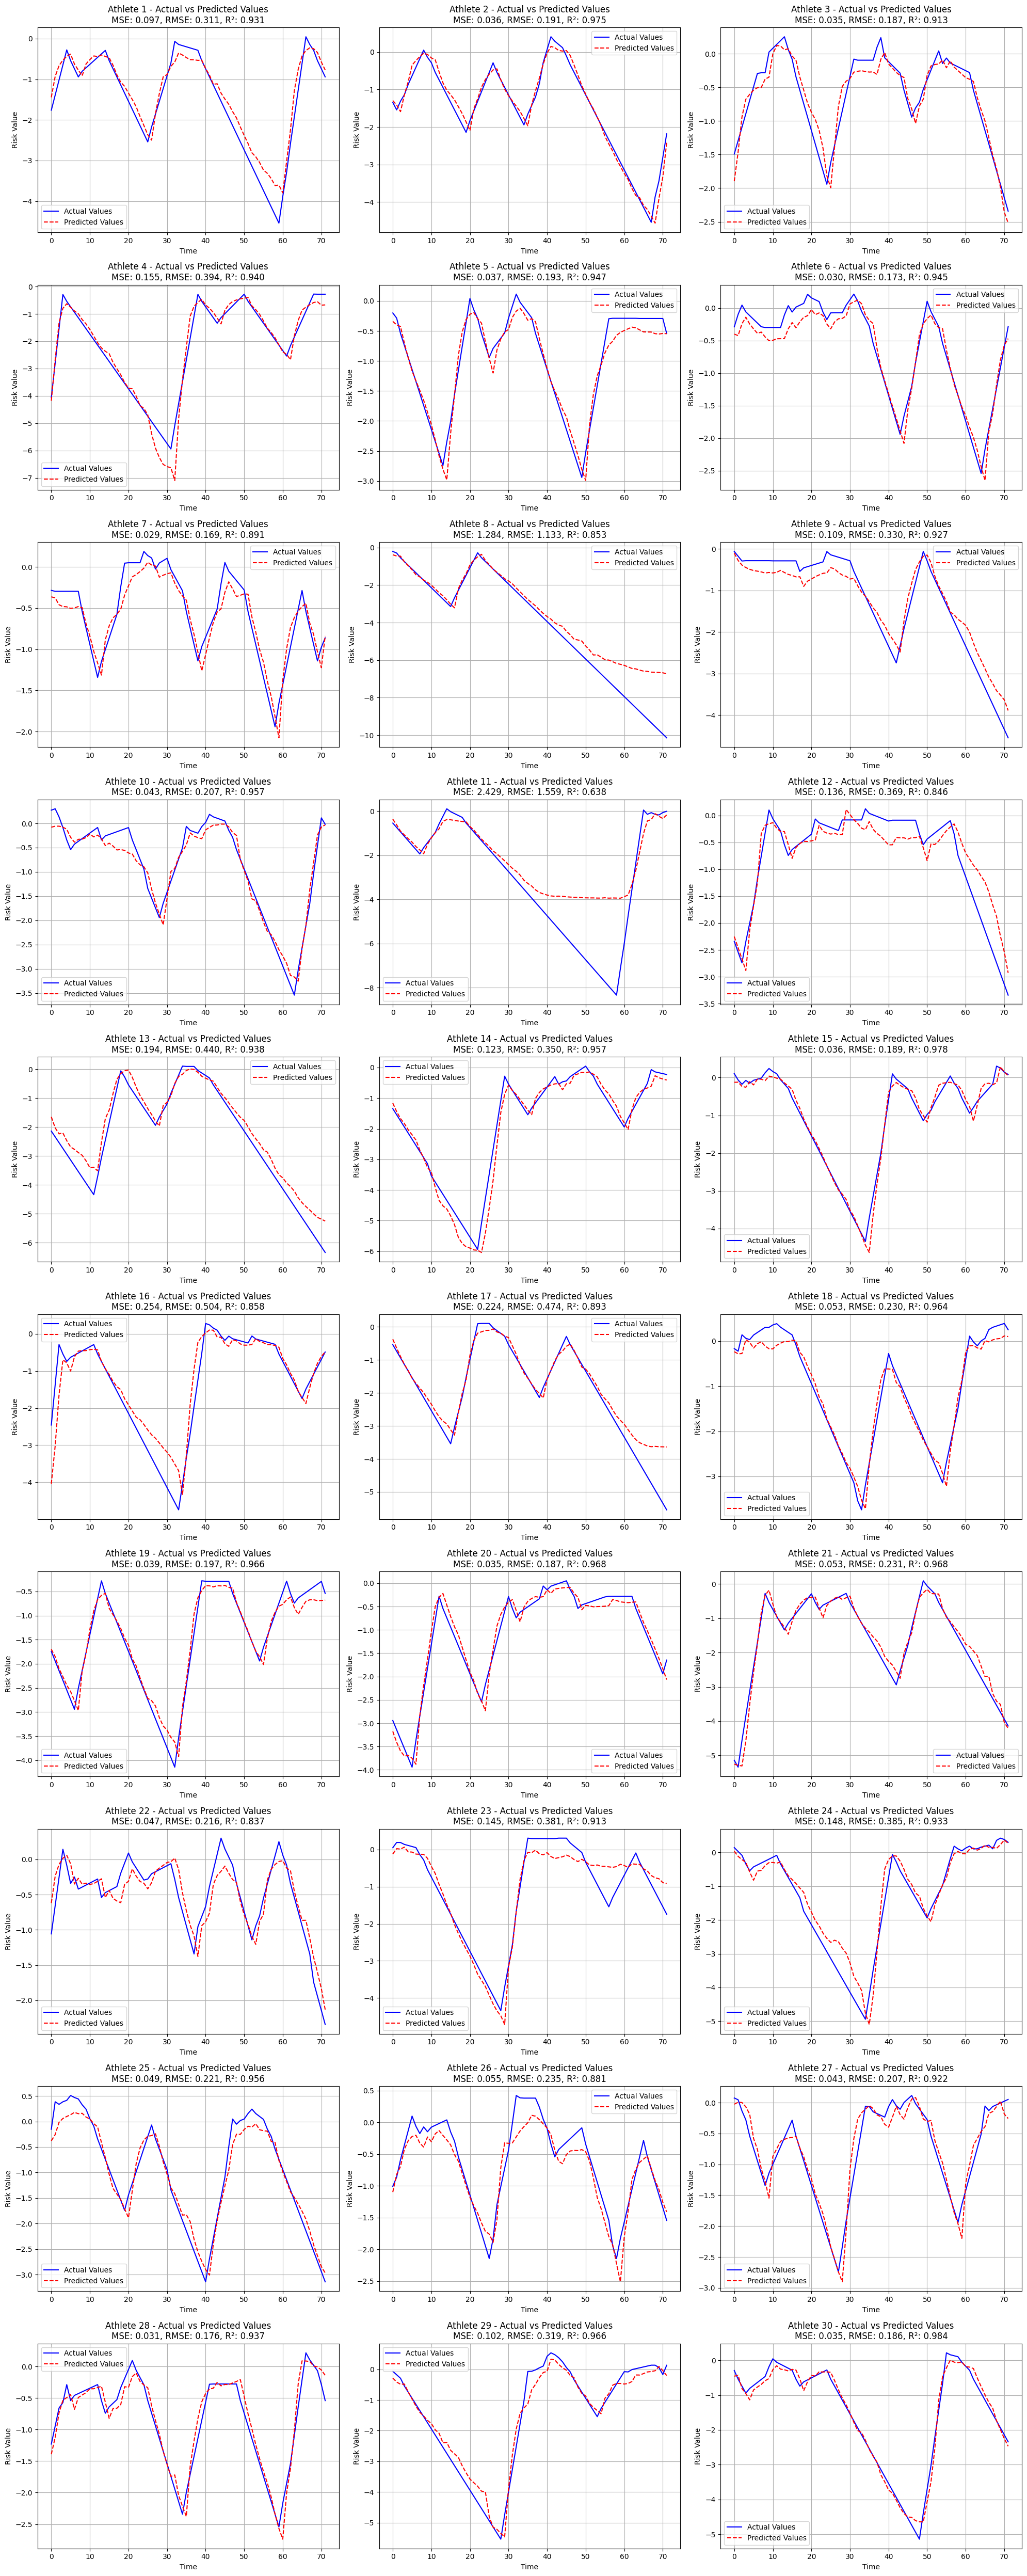

In [99]:
################
# VISUALIZATION
################


def plot_predictions_for_all_athletes(results):
    num_athletes = len(results)
    num_cols = 3
    num_rows = (num_athletes + num_cols - 1) // num_cols

    plt.figure(figsize=(20, 5 * num_rows))

    for idx, (athlete_id, result) in enumerate(results.items()):
        y_actual = result['predictions']['actual']
        y_predicted = result['predictions']['predicted']
        metrics = result['metrics']

        plt.subplot(num_rows, num_cols, idx + 1)
        time_steps = np.arange(len(y_actual))
        plt.plot(time_steps, y_actual, label='Actual Values', color='blue')
        plt.plot(time_steps, y_predicted, label='Predicted Values', color='red', linestyle='--')

        title = f'Athlete {athlete_id} - Actual vs Predicted Values\nMSE: {metrics["mse"]:.3f}, RMSE: {metrics["rmse"]:.3f}, R²: {metrics["r2"]:.3f}'
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Risk Value')

        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()


plot_predictions_for_all_athletes(results)

In [100]:
########################
# MONTHLY INJURY RISK
########################


def calculate_normalized_monthly_injury_risk(results, months=3):
    monthly_risks = {}
    for athlete_id, data in results.items():
        y_pred_orig = np.abs(data['predictions']['predicted'])
        min_risk, max_risk = y_pred_orig.min(), y_pred_orig.max()

        month_risks = []
        samples_per_month = len(y_pred_orig) // months

        for month in range(months):
            start = month * samples_per_month
            end = start + samples_per_month
            month_risk_raw = np.mean(y_pred_orig[start:end])

            month_risk = 100 * (month_risk_raw - min_risk) / (max_risk - min_risk)
            month_risks.append(month_risk)

        monthly_risks[athlete_id] = month_risks

    for athlete_id, risks in monthly_risks.items():
        print(f"\nAthlete {athlete_id} - Monthly Normalized Injury Risk Percentages:")
        for i, risk in enumerate(risks, 1):
            print(f"Month {i}: {risk:.2f}%")

    return monthly_risks

monthly_normalized_injury_risks = calculate_normalized_monthly_injury_risk(results)


Athlete 1 - Monthly Normalized Injury Risk Percentages:
Month 1: 17.30%
Month 2: 24.84%
Month 3: 50.90%

Athlete 2 - Monthly Normalized Injury Risk Percentages:
Month 1: 20.45%
Month 2: 15.49%
Month 3: 61.24%

Athlete 3 - Monthly Normalized Injury Risk Percentages:
Month 1: 23.72%
Month 2: 21.60%
Month 3: 30.38%

Athlete 4 - Monthly Normalized Injury Risk Percentages:
Month 1: 28.69%
Month 2: 40.01%
Month 3: 11.56%

Athlete 5 - Monthly Normalized Injury Risk Percentages:
Month 1: 38.80%
Month 2: 28.30%
Month 3: 30.22%

Athlete 6 - Monthly Normalized Injury Risk Percentages:
Month 1: 10.22%
Month 2: 25.86%
Month 3: 41.41%

Athlete 7 - Monthly Normalized Injury Risk Percentages:
Month 1: 26.36%
Month 2: 19.43%
Month 3: 42.96%

Athlete 8 - Monthly Normalized Injury Risk Percentages:
Month 1: 18.40%
Month 2: 38.46%
Month 3: 90.44%

Athlete 9 - Monthly Normalized Injury Risk Percentages:
Month 1: 12.22%
Month 2: 29.05%
Month 3: 48.31%

Athlete 10 - Monthly Normalized Injury Risk Percentage